Reference notebook :https://github.com/NVIDIAm-Merlin/NVTabular/blob/main/examples/02-Advanced-NVTabular-workflow.ipynb map

In [1]:
import os
import dotenv
dotenv.load_dotenv(".env")

True

### (1) Read The Data

In [2]:
from merlin.datasets.entertainment import get_movielens
input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))
get_movielens(variant="ml-1m", path=input_path); #noqa

--- Logging error ---
Traceback (most recent call last):
  File "/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/models/utils/nvt_utils.py", line 40, in _check_nvt_gpu
    import cudf  # noqa
ModuleNotFoundError: No module named 'cudf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/logging/__init__.py", line 1085, in emit
    msg = self.format(record)
  File "/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/logging/__init__.py", line 929, in format
    return fmt.format(record)
  File "/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/logging/__init__.py", line 668, in format
    record.message = record.getMessage()
  File "/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/logging/__init__.py", line 373, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Ca

In [3]:
from merlin.core.dispatch import get_lib

data = get_lib().read_parquet(f'{input_path}/ml-1m/train.parquet').sample(frac=1)

train = data.iloc[:600_000]
valid = data.iloc[600_000:]

movies = get_lib().read_parquet(f'{input_path}/ml-1m/movies_converted.parquet')


In [4]:
data.head()

,userId,movieId,rating,timestamp
198970,1222,3481,3,974919692
177152,1117,1792,3,975694001
710282,4260,3614,3,965323855
989811,5976,1961,4,956970197
417755,2522,1221,4,974064861


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


npartitions. We can leverage it to specify into how many chunks we would like our data to be split. Our workflow will process data in chunks and by increasing the number of partitions we can limit the memory footprint.

In [6]:
import nvtabular as nvt
from merlin.schema.tags import Tags

train_ds = nvt.Dataset(train, npartitions=2)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


(<merlin.io.dataset.Dataset at 0x29eb471c0>,
 <merlin.io.dataset.Dataset at 0x29eb47280>)

In [7]:
train_ds.head()

,userId,movieId,rating,timestamp
198970,1222,3481,3,974919692
177152,1117,1792,3,975694001
710282,4260,3614,3,965323855
989811,5976,1961,4,956970197
417755,2522,1221,4,974064861


In [8]:
train_ds.shuffle_by_keys('userId')
valid_ds.shuffle_by_keys('userId')

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


### (2) Define workflow



We want to make use of information contained in the movies DataFrame.

Let us join it onto our data, making sure we only select the genres column.


In [9]:
genres = ['movieId'] >> nvt.ops.JoinExternal(movies, on='movieId', columns_ext=['movieId', 'genres'])

In [10]:
movies['genres'].head()

0     [Animation, Children's, Comedy]
1    [Adventure, Children's, Fantasy]
2                   [Comedy, Romance]
3                     [Comedy, Drama]
4                            [Comedy]
Name: genres, dtype: object

Encoding a list of strings as categories

In [11]:
genres = genres >> nvt.ops.Categorify(freq_threshold=10)

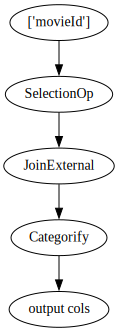

In [12]:
genres.graph


Running a custom preprocessing step

In [13]:
def rating_to_binary(col):
    return col > 3

In [14]:
binary_rating = ['rating'] >> nvt.ops.LambdaOp(rating_to_binary) >> nvt.ops.Rename(name='binary_rating')

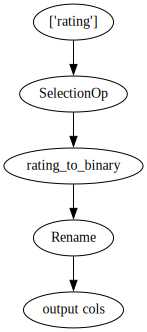

In [15]:
binary_rating.graph

Tagging columns
- Running NVTabular operators on our data automatically tags the output columns. For instance, the Categorify operator we used above will tag the output columns as Tags.CATEGORICAL. Still, some information that can be useful down the road needs to be added by hand. This is true for instance for target information. Let's add this information below.

In [16]:
userId = ['userId'] >> nvt.ops.Categorify() >> nvt.ops.AddTags(tags=[Tags.USER_ID, Tags.CATEGORICAL, Tags.USER])
movieId = ['movieId'] >> nvt.ops.Categorify() >> nvt.ops.AddTags(tags=[Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM])
binary_rating = binary_rating >> nvt.ops.AddTags(tags=[Tags.TARGET, Tags.BINARY_CLASSIFICATION])

Applying the workflow to the train and validation sets

In [17]:
workflow = nvt.Workflow(userId + movieId + genres + binary_rating)

In [18]:
train_transformed = workflow.fit_transform(train_ds)
valid_transformed = workflow.transform(valid_ds)
valid_transformed.compute().head()

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:407: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular D

,userId,movieId,genres,binary_rating
0,1331,884,[1],False
1,3166,10,"[3, 5, 4]",False
2,2643,572,"[3, 7, 5, 4]",False
3,293,7,"[3, 7, 5]",True
4,336,998,[1],False


In [19]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,userId,"(Tags.CATEGORICAL, Tags.USER, Tags.USER_ID, Ta...",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.userId.parquet,0.0,6040.0,userId,6041.0,210.0
1,movieId,"(Tags.CATEGORICAL, Tags.ID, Tags.ITEM_ID, Tags...",int64,False,False,NaN,10.0,0.0,0.0,.//categories/unique.movieId.parquet,0.0,3101.0,movieId,3102.0,144.0
2,genres,(Tags.CATEGORICAL),int64,True,True,NaN,10.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,18.0,genres,19.0,16.0
3,binary_rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)",bool,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### (3) Train Model

In [20]:
import tensorflow
import merlin.models.tf as mm

model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask('rating_binary')
)

2022-12-17 22:46:34.372015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 22:46:34.372338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [21]:
opt = tensorflow.optimizers.Adam(learning_rate=5e-3)
model.compile(optimizer=opt)
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=5)

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


Epoch 1/5


2022-12-17 22:46:42.960679: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-17 22:46:44.675770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 0.5613 - precision: 0.7148 - recall: 0.8222 - binary_accuracy: 0.7087 - auc: 0.7701 - regularization_loss: 0.0000e+00 - loss_batch: 0.5613

2022-12-17 22:47:02.734113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 24s 34ms/step - loss: 0.5613 - precision: 0.7148 - recall: 0.8222 - binary_accuracy: 0.7087 - auc: 0.7701 - regularization_loss: 0.0000e+00 - loss_batch: 0.5612 - val_loss: 0.5386 - val_precision: 0.7373 - val_recall: 0.8171 - val_binary_accuracy: 0.7274 - val_auc: 0.7932 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5327
Epoch 2/5
586/586 [==============================] - 19s 31ms/step - loss: 0.5175 - precision: 0.7523 - recall: 0.8189 - binary_accuracy: 0.7404 - auc: 0.8124 - regularization_loss: 0.0000e+00 - loss_batch: 0.5175 - val_loss: 0.5343 - val_precision: 0.7466 - val_recall: 0.8039 - val_binary_accuracy: 0.7302 - val_auc: 0.7976 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5287
Epoch 3/5
586/586 [==============================] - 19s 31ms/step - loss: 0.4762 - precision: 0.7881 - recall: 0.8149 - binary_accuracy: 0.7673 - auc: 0.8463 - regularization_loss: 0.0000e+00 - loss_batch: 0.4762 - val_loss: 0.5531

In [22]:
model.optimizer.learning_rate = 1e-3
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=3)

Epoch 1/3
586/586 [==============================] - 20s 32ms/step - loss: 0.1924 - precision: 0.9475 - recall: 0.9216 - binary_accuracy: 0.9255 - auc: 0.9752 - regularization_loss: 0.0000e+00 - loss_batch: 0.1925 - val_loss: 1.0931 - val_precision: 0.7302 - val_recall: 0.7328 - val_binary_accuracy: 0.6906 - val_auc: 0.7424 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.0545
Epoch 2/3
586/586 [==============================] - 19s 31ms/step - loss: 0.1562 - precision: 0.9633 - recall: 0.9382 - binary_accuracy: 0.9438 - auc: 0.9824 - regularization_loss: 0.0000e+00 - loss_batch: 0.1563 - val_loss: 1.1892 - val_precision: 0.7287 - val_recall: 0.7276 - val_binary_accuracy: 0.6875 - val_auc: 0.7347 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.1447
Epoch 3/3
586/586 [==============================] - 19s 31ms/step - loss: 0.1303 - precision: 0.9738 - recall: 0.9506 - binary_accuracy: 0.9568 - auc: 0.9865 - regularization_loss: 0.0000e+00 - loss_batch: 0.1303 - val_lo

In [23]:
valid_predictions = model.predict(valid_transformed,batch_size = 32)

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
2022-12-17 22:52:10.030517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [37]:
valid_transformed_ddf = valid_transformed.to_ddf()
valid_transformed_df = valid_transformed_ddf.compute()

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


In [38]:
valid_transformed_df['score']=valid_predictions[:,0]

In [39]:
valid_transformed_df.head()

,userId,movieId,genres,binary_rating,score
0,1331,884,[1],False,0.999966
1,3166,10,"[3, 5, 4]",False,0.063283
2,2643,572,"[3, 7, 5, 4]",False,0.002184
3,293,7,"[3, 7, 5]",True,0.007049
4,336,998,[1],False,0.999935


In [40]:
from sklearn import metrics

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(1*valid_transformed_df['binary_rating'],valid_transformed_df['score'], pos_label=1)

In [42]:
metrics.auc(fpr, tpr)

0.7337473186837996

In [43]:
# We can achieve all this by modifying the passed in schema using the without method.
model = mm.DLRMModel(
    train_transformed.schema.without('genres'),   # <--- this is where we make the change
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask('rating_binary')
)


In [44]:
opt = tensorflow.optimizers.Adam(learning_rate=5e-3)
model.compile(optimizer=opt)
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=5)

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


Epoch 1/5


2022-12-17 23:04:46.990700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 0.5994 - precision_1: 0.6664 - recall_1: 0.8408 - binary_accuracy: 0.6660 - auc_1: 0.7181 - regularization_loss: 0.0000e+00 - loss_batch: 0.5994

2022-12-17 23:05:02.293095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 19s 29ms/step - loss: 0.5994 - precision_1: 0.6664 - recall_1: 0.8408 - binary_accuracy: 0.6660 - auc_1: 0.7181 - regularization_loss: 0.0000e+00 - loss_batch: 0.5993 - val_loss: 0.5423 - val_precision_1: 0.7307 - val_recall_1: 0.8200 - val_binary_accuracy: 0.7226 - val_auc_1: 0.7894 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5347
Epoch 2/5
586/586 [==============================] - 16s 25ms/step - loss: 0.4520 - precision_1: 0.7973 - recall_1: 0.8435 - binary_accuracy: 0.7864 - auc_1: 0.8638 - regularization_loss: 0.0000e+00 - loss_batch: 0.4520 - val_loss: 0.5752 - val_precision_1: 0.7304 - val_recall_1: 0.7821 - val_binary_accuracy: 0.7086 - val_auc_1: 0.7734 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5888
Epoch 3/5
586/586 [==============================] - 16s 25ms/step - loss: 0.3302 - precision_1: 0.8625 - recall_1: 0.8926 - binary_accuracy: 0.8562 - auc_1: 0.9306 - regularization_loss: 0.0000e+00 - loss_ba

In [45]:
model.optimizer.learning_rate = 1e-3
metrics = model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=3)

Epoch 1/3
586/586 [==============================] - 17s 27ms/step - loss: 0.0979 - precision_1: 0.9665 - recall_1: 0.9746 - binary_accuracy: 0.9659 - auc_1: 0.9928 - regularization_loss: 0.0000e+00 - loss_batch: 0.0981 - val_loss: 1.3621 - val_precision_1: 0.7127 - val_recall_1: 0.7297 - val_binary_accuracy: 0.6754 - val_auc_1: 0.7252 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.3459
Epoch 2/3
586/586 [==============================] - 17s 26ms/step - loss: 0.0692 - precision_1: 0.9786 - recall_1: 0.9856 - binary_accuracy: 0.9793 - auc_1: 0.9953 - regularization_loss: 0.0000e+00 - loss_batch: 0.0694 - val_loss: 1.4998 - val_precision_1: 0.7113 - val_recall_1: 0.7296 - val_binary_accuracy: 0.6742 - val_auc_1: 0.7211 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.5056
Epoch 3/3
586/586 [==============================] - 16s 25ms/step - loss: 0.0528 - precision_1: 0.9858 - recall_1: 0.9907 - binary_accuracy: 0.9864 - auc_1: 0.9963 - regularization_loss: 0.0000e+00

In [46]:
valid_predictions = model.predict(valid_transformed,batch_size = 32)

2022-12-17 23:08:20.842213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [48]:
valid_transformed_df['score']=valid_predictions[:,0]

In [50]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(1*valid_transformed_df['binary_rating'],valid_transformed_df['score'], pos_label=1)

In [51]:
metrics.auc(fpr, tpr)

0.7279156599100589